<a href="https://colab.research.google.com/github/rmertoztop/project_4/blob/Jacob/Copy_of_NBA_Project_Main_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREDICTING NBA SCORE POINTS FOR NEXT SEASON

---

## SetUp Environment

In [ ]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example: spark_version = 'spark-3.3.1'
spark_version = 'spark-3.3.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Fetched 222 kB in 2s (128 kB/s)
Reading package lists... Done


# Import Packages

In [ ]:
# Import packages
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, StringType, DateType, IntegerType
from pyspark import SparkFiles
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from pyspark.sql.functions import col
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Create a SparkSession
spark = SparkSession.builder.appName("NBA_Prediction").getOrCreate()

In [ ]:
# Import data(season 2021/2022 and 2022/2023) using s3 bucket
url2022 = 'https://project4nba.s3.amazonaws.com/2022_2023_NBA_Player_Stats_Transformed.csv'

url2021 = 'https://project4nba.s3.amazonaws.com/2021_2022_NBA_Player_Stats_Transformed.csv'

In [ ]:
 # SparkFiles will allow you to resolves paths to files added through `SparkContext.addFile`
spark.sparkContext.addFile(url2022)

spark.sparkContext.addFile(url2021)

data2022 = spark.read.option('header', 'true').option("encoding", "utf-8").csv(SparkFiles.get("2022_2023_NBA_Player_Stats_Transformed.csv"), inferSchema=True, sep=',')

data2021 = spark.read.option('header', 'true').option("encoding", "utf-8").csv(SparkFiles.get("2021_2022_NBA_Player_Stats_Transformed.csv"), inferSchema=True, sep=';')

In [ ]:
# Show  first DataFrame
data2022.show()

+---+--------------------+---+---+---+---+---+----+----+----+-----+---+---+-----+----+----+-----+-----+---+----+-----+---+---+----+---+---+---+---+---+----+
| Rk|              Player|Pos|Age| Tm|  G| GS|  MP|  FG| FGA|  FG%| 3P|3PA|  3P%|  2P| 2PA|  2P%| eFG%| FT| FTA|  FT%|ORB|DRB| TRB|AST|STL|BLK|TOV| PF| PTS|
+---+--------------------+---+---+---+---+---+----+----+----+-----+---+---+-----+----+----+-----+-----+---+----+-----+---+---+----+---+---+---+---+---+----+
|  1|    Precious Achiuwa|  C| 23|TOR| 55| 12|20.7| 3.6| 7.3|0.485|0.5|2.0|0.269| 3.0| 5.4|0.564|0.521|1.6| 2.3|0.702|1.8|4.1| 6.0|0.9|0.6|0.5|1.1|1.9| 9.2|
|  2|        Steven Adams|  C| 29|MEM| 42| 42|27.0| 3.7| 6.3|0.597|0.0|0.0|  0.0| 3.7| 6.2|0.599|0.597|1.1| 3.1|0.364|5.1|6.5|11.5|2.3|0.9|1.1|1.9|2.3| 8.6|
|  3|         Bam Adebayo|  C| 25|MIA| 75| 75|34.6| 8.0|14.9| 0.54|0.0|0.2|0.083| 8.0|14.7|0.545|0.541|4.3| 5.4|0.806|2.5|6.7| 9.2|3.2|1.2|0.8|2.5|2.8|20.4|
|  4|        Ochai Agbaji| SG| 22|UTA| 59| 22|20.5| 2.8| 6

In [ ]:
# Show  second DataFrame
data2021.show()

+---+--------------------+---+---+---+---+---+----+----+----+-----+---+---+-----+---+----+-----+-----+---+----+-----+---+---+----+---+---+---+---+---+----+
| Rk|              Player|Pos|Age| Tm|  G| GS|  MP|  FG| FGA|  FG%| 3P|3PA|  3P%| 2P| 2PA|  2P%| eFG%| FT| FTA|  FT%|ORB|DRB| TRB|AST|STL|BLK|TOV| PF| PTS|
+---+--------------------+---+---+---+---+---+----+----+----+-----+---+---+-----+---+----+-----+-----+---+----+-----+---+---+----+---+---+---+---+---+----+
|  1|    Precious Achiuwa|  C| 22|TOR| 73| 28|23.6| 3.6| 8.3|0.439|0.8|2.1|0.359|2.9| 6.1|0.468|0.486|1.1| 1.8|0.595|2.0|4.5| 6.5|1.1|0.5|0.6|1.2|2.1| 9.1|
|  2|        Steven Adams|  C| 28|MEM| 76| 75|26.3| 2.8| 5.1|0.547|0.0|0.0|  0.0|2.8| 5.0|0.548|0.547|1.4| 2.6|0.543|4.6|5.4|10.0|3.4|0.9|0.8|1.5|2.0| 6.9|
|  3|         Bam Adebayo|  C| 24|MIA| 56| 56|32.6| 7.3|13.0|0.557|0.0|0.1|  0.0|7.3|12.9|0.562|0.557|4.6| 6.1|0.753|2.4|7.6|10.1|3.4|1.4|0.8|2.6|3.1|19.1|
|  4|        Santi Aldama| PF| 21|MEM| 32|  0|11.3| 1.7| 4.1|0.4

In [ ]:
#Convert Spark Dataframe to Pandas Dataframe
# 2022
nba_2022_2023_df = data2022.toPandas()
#2021
nba_2021_2022_df = data2021.toPandas()

In [ ]:
# display head of first dataframe
nba_2021_2022_df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Precious Achiuwa,C,22,TOR,73,28,23.6,3.6,8.3,...,0.595,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1
1,2,Steven Adams,C,28,MEM,76,75,26.3,2.8,5.1,...,0.543,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9
2,3,Bam Adebayo,C,24,MIA,56,56,32.6,7.3,13.0,...,0.753,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1
3,4,Santi Aldama,PF,21,MEM,32,0,11.3,1.7,4.1,...,0.625,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1
4,5,LaMarcus Aldridge,C,36,BRK,47,12,22.3,5.4,9.7,...,0.873,1.6,3.9,5.5,0.9,0.3,1.0,0.9,1.7,12.9


In [ ]:
# display head of second dataframe
nba_2022_2023_df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Precious Achiuwa,C,23,TOR,55,12,20.7,3.6,7.3,...,0.702,1.8,4.1,6.0,0.9,0.6,0.5,1.1,1.9,9.2
1,2,Steven Adams,C,29,MEM,42,42,27.0,3.7,6.3,...,0.364,5.1,6.5,11.5,2.3,0.9,1.1,1.9,2.3,8.6
2,3,Bam Adebayo,C,25,MIA,75,75,34.6,8.0,14.9,...,0.806,2.5,6.7,9.2,3.2,1.2,0.8,2.5,2.8,20.4
3,4,Ochai Agbaji,SG,22,UTA,59,22,20.5,2.8,6.5,...,0.812,0.7,1.3,2.1,1.1,0.3,0.3,0.7,1.7,7.9
4,5,Santi Aldama,PF,22,MEM,77,20,21.8,3.2,6.8,...,0.750,1.1,3.7,4.8,1.3,0.6,0.6,0.8,1.9,9.0


# Data Cleaning

In [ ]:
# Merge both dataframe using outer join
joined_data = nba_2022_2023_df.merge(nba_2021_2022_df, on='Player', how='outer')

In [ ]:
# show head of joined dataframe
joined_data.head()

,Rk_x,Player,Pos_x,Age_x,Tm_x,G_x,GS_x,MP_x,FG_x,FGA_x,...,FT%_y,ORB_y,DRB_y,TRB_y,AST_y,STL_y,BLK_y,TOV_y,PF_y,PTS_y
0,1.0,Precious Achiuwa,C,23.0,TOR,55.0,12.0,20.7,3.6,7.3,...,0.595,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1
1,2.0,Steven Adams,C,29.0,MEM,42.0,42.0,27.0,3.7,6.3,...,0.543,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9
2,3.0,Bam Adebayo,C,25.0,MIA,75.0,75.0,34.6,8.0,14.9,...,0.753,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1
3,4.0,Ochai Agbaji,SG,22.0,UTA,59.0,22.0,20.5,2.8,6.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,Santi Aldama,PF,22.0,MEM,77.0,20.0,21.8,3.2,6.8,...,0.625,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1


In [ ]:
# Check for missing values
joined_data.isna().sum()

Rk_x      269
Player      0
Pos_x     269
Age_x     269
Tm_x      269
G_x       269
GS_x      269
MP_x      269
FG_x      269
FGA_x     269
FG%_x     269
3P_x      269
3PA_x     269
3P%_x     269
2P_x      269
2PA_x     269
2P%_x     269
eFG%_x    269
FT_x      269
FTA_x     269
FT%_x     269
ORB_x     269
DRB_x     269
TRB_x     269
AST_x     269
STL_x     269
BLK_x     269
TOV_x     269
PF_x      269
PTS_x     269
Rk_y      127
Pos_y     127
Age_y     127
Tm_y      127
G_y       127
GS_y      127
MP_y      127
FG_y      127
FGA_y     127
FG%_y     127
3P_y      127
3PA_y     127
3P%_y     127
2P_y      127
2PA_y     127
2P%_y     127
eFG%_y    127
FT_y      127
FTA_y     127
FT%_y     127
ORB_y     127
DRB_y     127
TRB_y     127
AST_y     127
STL_y     127
BLK_y     127
TOV_y     127
PF_y      127
PTS_y     127
dtype: int64

In [ ]:
# Dropping missing values
joined_data.dropna(inplace = True)

In [ ]:
# Confirm missing values are removed
joined_data.isna().sum()

Rk_x      0
Player    0
Pos_x     0
Age_x     0
Tm_x      0
G_x       0
GS_x      0
MP_x      0
FG_x      0
FGA_x     0
FG%_x     0
3P_x      0
3PA_x     0
3P%_x     0
2P_x      0
2PA_x     0
2P%_x     0
eFG%_x    0
FT_x      0
FTA_x     0
FT%_x     0
ORB_x     0
DRB_x     0
TRB_x     0
AST_x     0
STL_x     0
BLK_x     0
TOV_x     0
PF_x      0
PTS_x     0
Rk_y      0
Pos_y     0
Age_y     0
Tm_y      0
G_y       0
GS_y      0
MP_y      0
FG_y      0
FGA_y     0
FG%_y     0
3P_y      0
3PA_y     0
3P%_y     0
2P_y      0
2PA_y     0
2P%_y     0
eFG%_y    0
FT_y      0
FTA_y     0
FT%_y     0
ORB_y     0
DRB_y     0
TRB_y     0
AST_y     0
STL_y     0
BLK_y     0
TOV_y     0
PF_y      0
PTS_y     0
dtype: int64

In [ ]:
# shape of the dataset
joined_data.shape

(707, 59)

In [ ]:
# Check data type
joined_data.dtypes

Rk_x      float64
Player     object
Pos_x      object
Age_x     float64
Tm_x       object
G_x       float64
GS_x      float64
MP_x      float64
FG_x      float64
FGA_x     float64
FG%_x     float64
3P_x      float64
3PA_x     float64
3P%_x     float64
2P_x      float64
2PA_x     float64
2P%_x     float64
eFG%_x    float64
FT_x      float64
FTA_x     float64
FT%_x     float64
ORB_x     float64
DRB_x     float64
TRB_x     float64
AST_x     float64
STL_x     float64
BLK_x     float64
TOV_x     float64
PF_x      float64
PTS_x     float64
Rk_y      float64
Pos_y      object
Age_y     float64
Tm_y       object
G_y       float64
GS_y      float64
MP_y      float64
FG_y      float64
FGA_y     float64
FG%_y     float64
3P_y      float64
3PA_y     float64
3P%_y     float64
2P_y      float64
2PA_y     float64
2P%_y     float64
eFG%_y    float64
FT_y      float64
FTA_y     float64
FT%_y     float64
ORB_y     float64
DRB_y     float64
TRB_y     float64
AST_y     float64
STL_y     float64
BLK_y     

In [ ]:
# Set index of data to player
joined_data = joined_data.set_index('Player')

In [ ]:
# Check data
joined_data.head()

,Rk_x,Pos_x,Age_x,Tm_x,G_x,GS_x,MP_x,FG_x,FGA_x,FG%_x,...,FT%_y,ORB_y,DRB_y,TRB_y,AST_y,STL_y,BLK_y,TOV_y,PF_y,PTS_y
Player,,,,,,,,,,,,,,,,,,,,,
Precious Achiuwa,1.0,C,23.0,TOR,55.0,12.0,20.7,3.6,7.3,0.485,...,0.595,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1
Steven Adams,2.0,C,29.0,MEM,42.0,42.0,27.0,3.7,6.3,0.597,...,0.543,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9
Bam Adebayo,3.0,C,25.0,MIA,75.0,75.0,34.6,8.0,14.9,0.540,...,0.753,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1
Santi Aldama,5.0,PF,22.0,MEM,77.0,20.0,21.8,3.2,6.8,0.470,...,0.625,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1
Nickeil Alexander-Walker,6.0,SG,24.0,TOT,59.0,3.0,15.0,2.2,5.0,0.444,...,0.743,0.6,2.3,2.9,2.4,0.7,0.4,1.4,1.6,10.6


# Data Modelling

In [ ]:
# Select the features (X) and target variables (y) for points prediction
# Drop columns not needed
features = joined_data.drop(['PTS_x', 'Pos_x', 'Pos_y', 'Tm_x', 'Tm_y', 'Rk_y', 'Rk_x'], axis = 1)
# set target to points
target_pts = joined_data[['PTS_x']]

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train_pts, y_test_pts = train_test_split(features, target_pts, test_size=0.25, random_state=42)

## Linear Regression

In [ ]:
# import the regressor
from sklearn.linear_model import LinearRegression

# make the regressor object
model_pts = LinearRegression()

# Train the models
model_pts.fit(X_train, y_train_pts)

LinearRegression()

In [ ]:
# Make predictions for the input testing data using the linear regression Model
pts_predictions_linear = model_pts.predict(X_test)

#### Model Accuracy

In [ ]:
# Calculate R-squared and MSE for the linear regression model
# r-squared
r_squared = model_pts.score(X_train, y_train_pts)
print("Linear Regression R-squared:", r_squared)
# MSE
print('MSE Linear Regression: %.3f' %np.sqrt(metrics.mean_squared_error(y_test_pts, pts_predictions_linear)))


Linear Regression R-squared: 0.999886061633242
MSE Linear Regression: 0.077


## RandomForestRegressor

In [ ]:
# import the regressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# make the regressor object
model_pts_forest = RandomForestRegressor()

In [ ]:
# fit the regressor with X and y data
model_pts_forest.fit(X_train, y_train_pts)

<ipython-input-27-d5fdbd4d2480>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_pts_forest.fit(X_train, y_train_pts)


RandomForestRegressor()

In [ ]:
# Make predictions for the input testing data using the Random Forest Regressor Model
pts_predictions_forest = model_pts_forest.predict(X_test)

#### Model accuracy

In [ ]:
# Calculate R-squared for the random regressor model
r_squared_forest = model_pts_forest.score(X_train, y_train_pts)

# compare model accuracy to linear regression
print("Linear Regression R-squared:", r_squared)
print("Random Forest Regression R-squared:", r_squared_forest)
print("-----------------------------")
# MSE
print('MSE Linear Regression: %.3f' %np.sqrt(metrics.mean_squared_error(y_test_pts, pts_predictions_linear)))
print('MSE for Random Forest Regression: %.3f' %np.sqrt(metrics.mean_squared_error(y_test_pts, pts_predictions_forest)))

Linear Regression R-squared: 0.999886061633242
Random Forest Regression R-squared: 0.9987118994178104
-----------------------------
MSE Linear Regression: 0.077
MSE for Random Forest Regression: 0.548


## Decission TreeRegressor

In [ ]:
# import the regressor
from sklearn.tree import DecisionTreeRegressor

# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0)

# fit the regressor with X and y data
regressor.fit(X_train, y_train_pts)

DecisionTreeRegressor(random_state=0)

In [ ]:
# Make predictions for the input testing data using the Decission Tree Regressor
pts_predictions_decission = regressor.predict(X_test)

#### Model Accuracy

In [ ]:
# model accuracy for decission tree regressor
r_squared_decissiontree = regressor.score(X_train, y_train_pts)

# compare model accuracy to linear regression and random forest regression model
print("Linear Regression R-squared:", r_squared)
print("Random Forest Regression R-squared:", r_squared_forest)
print("Random Decission tree R-squared:", r_squared_decissiontree)
print("-----------------------------")
# MSE
print('MSE Linear Regression: %.3f' %np.sqrt(metrics.mean_squared_error(y_test_pts, pts_predictions_linear)))
print('MSE for Random Forest Regression: %.3f' %np.sqrt(metrics.mean_squared_error(y_test_pts, pts_predictions_forest)))
print('MSE for Decission TreeRegression: %.3f' %np.sqrt(metrics.mean_squared_error(y_test_pts, pts_predictions_decission)))

Linear Regression R-squared: 0.999886061633242
Random Forest Regression R-squared: 0.9987118994178104
Random Decission tree R-squared: 1.0
-----------------------------
MSE Linear Regression: 0.077
MSE for Random Forest Regression: 0.548
MSE for Decission TreeRegression: 1.041


## Lasso Model

In [ ]:
# import the regressor
from sklearn import linear_model

# create a regressor object
clf = linear_model.Lasso(alpha=0.1, random_state = 42)

# fit the regressor with X and y data
clf.fit(X_train, y_train_pts)

Lasso(alpha=0.1, random_state=42)

In [ ]:
# Make predictions for the input testing data using the Decission Tree Regressor
pts_predictions_clf = clf.predict(X_test)

#### Model Accuracy

In [ ]:
# model accuracy for Lasso regressor
r_squared_lasso = clf.score(X_train, y_train_pts)

# compare model accuracy to linear regression, random forest regression model and Decission TreeRegressor
print("Linear Regression R-squared:", r_squared)
print("Random Forest Regression R-squared:", r_squared_forest)
print("Random Decission tree R-squared:", r_squared_decissiontree)
print("Lasso Regression tree R-squared:", r_squared_lasso)
print("-----------------------------")
# MSE
print('MSE Linear Regression: %.3f' %np.sqrt(metrics.mean_squared_error(y_test_pts, pts_predictions_linear)))
print('MSE for Random Forest Regression: %.3f' %np.sqrt(metrics.mean_squared_error(y_test_pts, pts_predictions_forest)))
print('MSE for Decission TreeRegression: %.3f' %np.sqrt(metrics.mean_squared_error(y_test_pts, pts_predictions_decission)))
print('MSE for Lasso Regression: %.3f' %np.sqrt(metrics.mean_squared_error(y_test_pts, pts_predictions_clf)))

Linear Regression R-squared: 0.999886061633242
Random Forest Regression R-squared: 0.9987118994178104
Random Decission tree R-squared: 1.0
Random Decission tree R-squared: 0.998271166650121
-----------------------------
MSE Linear Regression: 0.077
MSE for Random Forest Regression: 0.548
MSE for Decission TreeRegression: 1.041
MSE for Lasso Regression: 0.256


## Make predictions for each player using the Linear Regression Model

In [ ]:
# Make predictions for each player using the Linear Regression Model
# Get the entire data
full_set = pd.concat([X_train, X_test])

# Make predictions for entire data using Linear regression
pts_predictions = model_pts.predict(full_set)

#Testing Prediction using Random Player

In [ ]:
# Get all unique Players
player_names = full_set.index.unique()

In [ ]:
# Import Random
import random

# Make prediction for randomly selected player
player_names = joined_data.index.unique()
select_player = random.choice(player_names)
player_row = joined_data[joined_data.index == select_player]
player_features = player_row.drop(['PTS_x', 'Pos_x', 'Pos_y', 'Tm_x', 'Tm_y', 'Rk_y', 'Rk_x'], axis = 1)

In [ ]:
# Get the actual points for the player
pts_actual = player_row[['PTS_x']].values[0]
pts_actual_2021 = player_row[['PTS_y']].values[0]
# Predict points and assists for the player
pts_predicted = model_pts.predict(player_features)[0]
print("Player:", select_player)
print("2021-2022 Points:", pts_actual_2021)
print("2022-2023 Points:", pts_actual)
print("2023-2024 Predicted Points:", pts_predicted)


Player: Steven Adams
2021-2022 Points: [6.9]
2022-2023 Points: [8.6]
2023-2024 Predicted Points: [8.55203405]


## Further Data Cleaning

In [ ]:
# Drop 2021-2022 NBA age
columns_to_drop = ['Age_y']
joined_data.drop(columns=columns_to_drop, inplace=True)

In [ ]:
# Confirm Age_y was dropped
joined_data.columns

Index(['Rk_x', 'Pos_x', 'Age_x', 'Tm_x', 'G_x', 'GS_x', 'MP_x', 'FG_x',
       'FGA_x', 'FG%_x', '3P_x', '3PA_x', '3P%_x', '2P_x', '2PA_x', '2P%_x',
       'eFG%_x', 'FT_x', 'FTA_x', 'FT%_x', 'ORB_x', 'DRB_x', 'TRB_x', 'AST_x',
       'STL_x', 'BLK_x', 'TOV_x', 'PF_x', 'PTS_x', 'Rk_y', 'Pos_y', 'Tm_y',
       'G_y', 'GS_y', 'MP_y', 'FG_y', 'FGA_y', 'FG%_y', '3P_y', '3PA_y',
       '3P%_y', '2P_y', '2PA_y', '2P%_y', 'eFG%_y', 'FT_y', 'FTA_y', 'FT%_y',
       'ORB_y', 'DRB_y', 'TRB_y', 'AST_y', 'STL_y', 'BLK_y', 'TOV_y', 'PF_y',
       'PTS_y'],
      dtype='object')

In [ ]:
# Rename Columns
renamed_columns = {}
for col in joined_data.columns:
    if col.endswith('_x'):
        renamed_columns[col] = col[:-2] + '_2022_2023'
    elif col.endswith('_y'):
        renamed_columns[col] = col[:-2] + '_2021_2022'
joined_data.rename(columns=renamed_columns, inplace=True)


#Exporting CSV for Visualizations

In [ ]:
# Create a copy of pandas_df
pandas_df_with_predictions = joined_data.copy()

# Add the predictions as new columns
pandas_df_with_predictions['2023-2024 Predicted Points'] = pts_predictions

# Set negative predictions to 0
pandas_df_with_predictions.loc[pandas_df_with_predictions['2023-2024 Predicted Points'] < 0, '2023-2024 Predicted Points'] = 0

#Reset index and add as column

pandas_df_with_predictions = pandas_df_with_predictions.reset_index(drop = False)

# Specify the path where you want to save the file
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/NBA Predicted Data.csv'
# Save the DataFrame as a CSV file
pandas_df_with_predictions.to_csv(file_path, encoding='utf-8', index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Create Visulizations

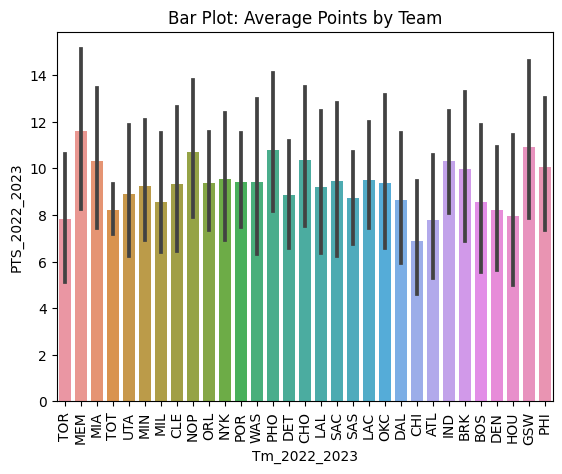

In [ ]:
# Make a bar plot
sns.barplot(x='Tm_2022_2023', y='PTS_2022_2023', data=pandas_df_with_predictions)
plt.title('Bar Plot: Average Points by Team')
plt.xticks(rotation=90)
plt.show()


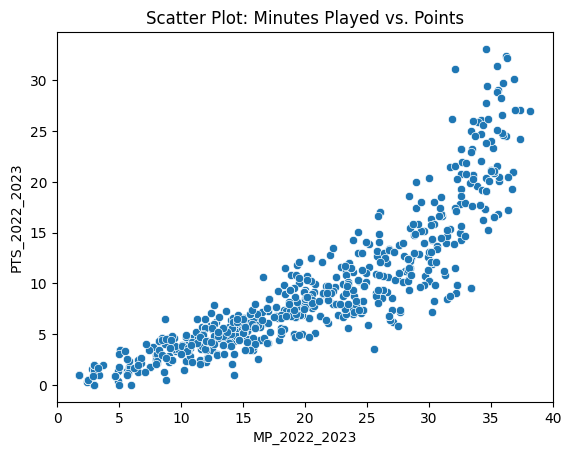

In [ ]:
#Make a scatter plot
sns.scatterplot(x='MP_2022_2023', y='PTS_2022_2023', data=pandas_df_with_predictions)
plt.title('Scatter Plot: Minutes Played vs. Points')
plt.show()


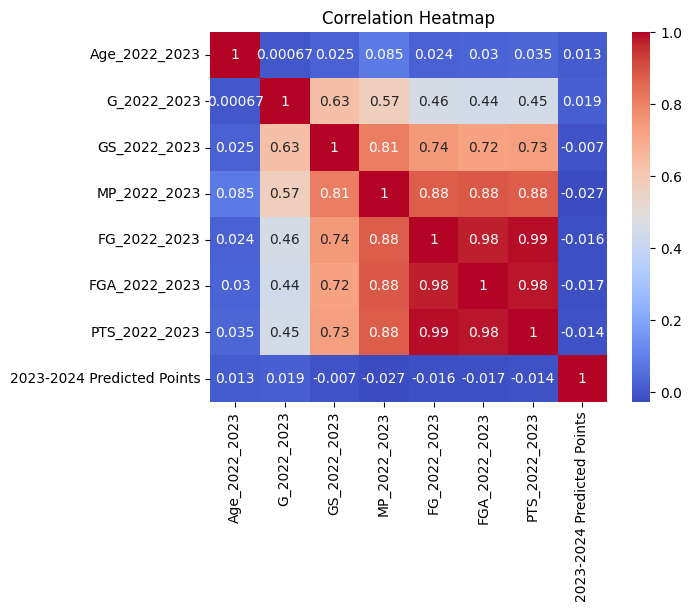

In [ ]:
# Make a Correlation Heat Map
numeric_columns = ['Age_2022_2023', 'G_2022_2023', 'GS_2022_2023', 'MP_2022_2023', 'FG_2022_2023', 'FGA_2022_2023', 'PTS_2022_2023', '2023-2024 Predicted Points']
numeric_data = pandas_df_with_predictions[numeric_columns]
corr_matrix = numeric_data.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
